# 01 — Preprocessing & EDA (Beijing Multi-Site Air Quality)
Mục tiêu: tải dữ liệu, làm sạch, tạo nhãn phân lớp (AQI class theo PM2.5 24h mean), tạo đặc trưng thời gian + lag, và lưu `data/processed/cleaned.parquet`.

**Lưu ý:** nếu `USE_UCIMLREPO=True` thì notebook cần internet để tải dataset từ UCI.

In [1]:
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"

OUTPUT_CLEANED_PATH = 'data/processed/cleaned.parquet'
LAG_HOURS=[1, 3, 24]


In [2]:
# Parameters
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
OUTPUT_CLEANED_PATH = "data/processed/cleaned.parquet"
LAG_HOURS = [1, 3, 24]


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_pm25_24h_and_label,
    add_time_features,
    add_lag_features,
)

PROJECT_ROOT = Path('..').resolve()
OUT_PATH = (PROJECT_ROOT / OUTPUT_CLEANED_PATH).resolve()
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)

In [4]:
df_raw = load_beijing_air_quality(use_ucimlrepo=USE_UCIMLREPO, raw_zip_path=RAW_ZIP_PATH)
print('raw shape:', df_raw.shape)
df_raw.head()

raw shape: (420768, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
df = clean_air_quality_df(df_raw)
df = add_pm25_24h_and_label(df)
df = add_time_features(df)
df = add_lag_features(df, lag_hours=LAG_HOURS)
print('cleaned shape:', df.shape)
df[['datetime','station','PM2.5','pm25_24h','aqi_class']].head(10)

cleaned shape: (420768, 55)


,datetime,station,PM2.5,pm25_24h,aqi_class
0,2013-03-01 00:00:00,Aotizhongxin,4.0,NaN,NaN
1,2013-03-01 01:00:00,Aotizhongxin,8.0,NaN,NaN
2,2013-03-01 02:00:00,Aotizhongxin,7.0,NaN,NaN
3,2013-03-01 03:00:00,Aotizhongxin,6.0,NaN,NaN
4,2013-03-01 04:00:00,Aotizhongxin,3.0,NaN,NaN
5,2013-03-01 05:00:00,Aotizhongxin,5.0,NaN,NaN
6,2013-03-01 06:00:00,Aotizhongxin,3.0,NaN,NaN
7,2013-03-01 07:00:00,Aotizhongxin,3.0,NaN,NaN
8,2013-03-01 08:00:00,Aotizhongxin,3.0,NaN,NaN
9,2013-03-01 09:00:00,Aotizhongxin,3.0,NaN,NaN


In [6]:
# EDA nhanh: missingness và phân bố lớp
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate.head(20)

CO_lag24      0.049849
CO_lag3       0.049284
CO_lag1       0.049227
CO            0.049198
O3_lag24      0.032203
O3_lag3       0.031640
O3_lag1       0.031583
O3            0.031554
NO2_lag24     0.029446
NO2_lag3      0.028881
NO2_lag1      0.028823
NO2           0.028795
SO2_lag24     0.022091
SO2_lag3      0.021525
SO2_lag1      0.021468
SO2           0.021439
PM2.5         0.020769
pm25_24h      0.018616
aqi_class     0.018616
PM10_lag24    0.015990
dtype: float64

## Q1.1 — Kiểm tra phạm vi thời gian và tần suất dữ liệu
Mục tiêu: xác nhận dữ liệu phủ từ khi nào đến khi nào, tần suất theo giờ có liên tục không, và có gap nào không.

In [7]:
# Kiểm tra phạm vi thời gian
print("="*60)
print("KIỂM TRA PHẠM VI THỜI GIAN VÀ TẦN SUẤT DỮ LIỆU")
print("="*60)

print(f"\n📅 Khoảng thời gian dữ liệu:")
print(f"   Start: {df['datetime'].min()}")
print(f"   End:   {df['datetime'].max()}")
print(f"   Tổng số bản ghi: {len(df):,}")

# Kiểm tra số trạm
stations = df['station'].unique()
print(f"\n📍 Số trạm quan trắc: {len(stations)}")
print(f"   Các trạm: {list(stations)}")

# Kiểm tra tần suất theo giờ - lấy 1 trạm để kiểm tra
sample_station = stations[0]
df_station = df[df['station'] == sample_station].sort_values('datetime')
time_diff = df_station['datetime'].diff().dropna()

print(f"\n⏰ Kiểm tra tần suất (trạm {sample_station}):")
print(f"   Khoảng cách thời gian phổ biến nhất: {time_diff.mode().iloc[0]}")
print(f"   Khoảng cách thời gian min: {time_diff.min()}")
print(f"   Khoảng cách thời gian max: {time_diff.max()}")

# Kiểm tra gaps (khoảng trống > 1 giờ)
gaps = time_diff[time_diff > pd.Timedelta(hours=1)]
if len(gaps) > 0:
    print(f"\n⚠️  Phát hiện {len(gaps)} gaps (khoảng trống > 1 giờ):")
    print(gaps.value_counts().head(10))
else:
    print(f"\n✅ Không có gaps - dữ liệu liên tục theo giờ")

# Tính số giờ lý thuyết
expected_hours = int((df['datetime'].max() - df['datetime'].min()).total_seconds() / 3600) + 1
actual_hours_per_station = len(df_station)
print(f"\n📊 Số giờ lý thuyết: {expected_hours:,}")
print(f"   Số giờ thực tế mỗi trạm: {actual_hours_per_station:,}")

KIỂM TRA PHẠM VI THỜI GIAN VÀ TẦN SUẤT DỮ LIỆU

📅 Khoảng thời gian dữ liệu:
   Start: 2013-03-01 00:00:00
   End:   2017-02-28 23:00:00
   Tổng số bản ghi: 420,768

📍 Số trạm quan trắc: 12
   Các trạm: ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']

⏰ Kiểm tra tần suất (trạm Aotizhongxin):
   Khoảng cách thời gian phổ biến nhất: 0 days 01:00:00
   Khoảng cách thời gian min: 0 days 01:00:00
   Khoảng cách thời gian max: 0 days 01:00:00

✅ Không có gaps - dữ liệu liên tục theo giờ

📊 Số giờ lý thuyết: 35,064
   Số giờ thực tế mỗi trạm: 35,064


## Q1.2 — Phân tích tỷ lệ thiếu dữ liệu theo biến và theo thời gian
Mục tiêu: Xác định biến nào thiếu nhiều nhất, và thiếu tập trung vào giai đoạn nào hay rải đều.

PHÂN TÍCH TỶ LỆ THIẾU DỮ LIỆU

📊 Tỷ lệ thiếu theo biến (%):
   CO      : █████████░░░░░░░░░░ 4.92%
   O3      : ██████░░░░░░░░░░░░░ 3.16%
   NO2     : █████░░░░░░░░░░░░░░ 2.88%
   SO2     : ████░░░░░░░░░░░░░░░ 2.14%
   PM2.5   : ████░░░░░░░░░░░░░░░ 2.08%
   PM10    : ███░░░░░░░░░░░░░░░░ 1.53%
   wd      : ░░░░░░░░░░░░░░░░░░░ 0.43%
   DEWP    : ░░░░░░░░░░░░░░░░░░░ 0.10%
   TEMP    : ░░░░░░░░░░░░░░░░░░░ 0.09%
   PRES    : ░░░░░░░░░░░░░░░░░░░ 0.09%
   RAIN    : ░░░░░░░░░░░░░░░░░░░ 0.09%
   WSPM    : ░░░░░░░░░░░░░░░░░░░ 0.08%


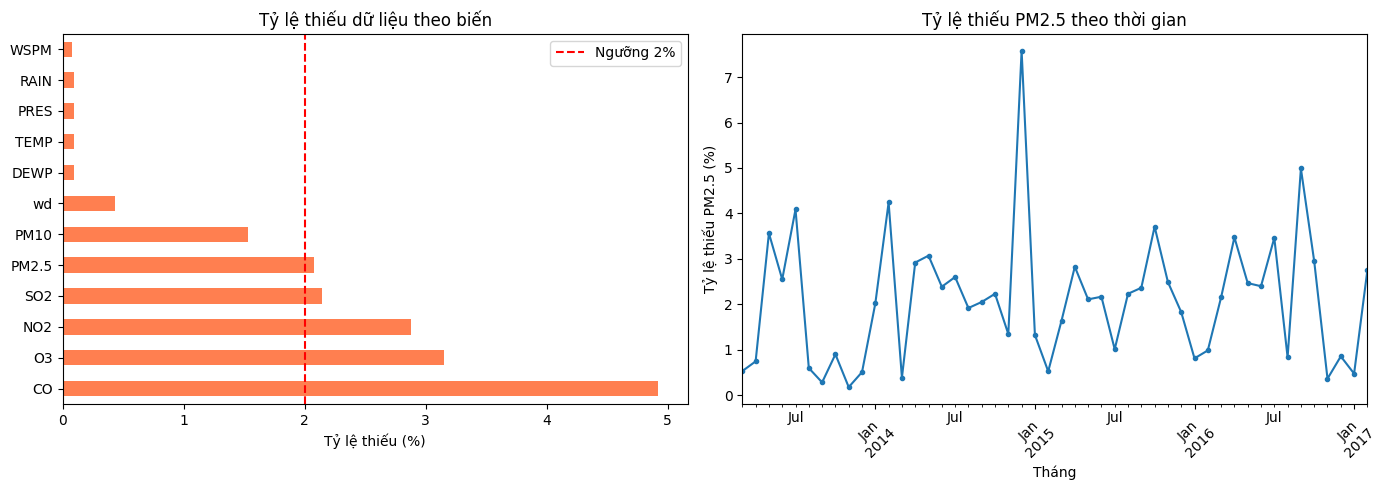


📍 Tỷ lệ thiếu PM2.5 theo trạm:
   Huairou             : 2.72%
   Aotizhongxin        : 2.64%
   Shunyi              : 2.60%
   Dingling            : 2.22%
   Changping           : 2.21%
   Dongsi              : 2.14%
   Wanshouxigong       : 1.98%
   Tiantan             : 1.93%
   Gucheng             : 1.84%
   Nongzhanguan        : 1.79%
   Guanyuan            : 1.76%
   Wanliu              : 1.09%


In [8]:
# Tỷ lệ thiếu theo biến
print("="*60)
print("PHÂN TÍCH TỶ LỆ THIẾU DỮ LIỆU")
print("="*60)

# Các biến quan trọng cần phân tích
important_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd']
missing_by_var = df[important_cols].isna().mean().sort_values(ascending=False) * 100

print("\n📊 Tỷ lệ thiếu theo biến (%):")
for col, rate in missing_by_var.items():
    bar = "█" * int(rate * 2) + "░" * int((10 - rate) * 2)
    print(f"   {col:8s}: {bar} {rate:.2f}%")

# Visualize missing rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart - missing rate by variable
ax1 = axes[0]
missing_by_var.plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Tỷ lệ thiếu (%)')
ax1.set_title('Tỷ lệ thiếu dữ liệu theo biến')
ax1.axvline(x=2, color='red', linestyle='--', label='Ngưỡng 2%')
ax1.legend()

# Missing over time - theo tháng
df['year_month'] = df['datetime'].dt.to_period('M')
missing_by_month = df.groupby('year_month')['PM2.5'].apply(lambda x: x.isna().mean() * 100)

ax2 = axes[1]
missing_by_month.plot(kind='line', ax=ax2, marker='o', markersize=3)
ax2.set_xlabel('Tháng')
ax2.set_ylabel('Tỷ lệ thiếu PM2.5 (%)')
ax2.set_title('Tỷ lệ thiếu PM2.5 theo thời gian')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Phân tích thiếu theo trạm cho PM2.5
print("\n📍 Tỷ lệ thiếu PM2.5 theo trạm:")
missing_by_station = df.groupby('station')['PM2.5'].apply(lambda x: x.isna().mean() * 100).sort_values(ascending=False)
for station, rate in missing_by_station.items():
    print(f"   {station:20s}: {rate:.2f}%")

## Q1.3 — Phát hiện outliers và phân phối lệch
Mục tiêu: Dùng boxplot và quantile để nhìn nhanh các giá trị ngoại lai và phân phối của PM2.5, PM10.

PHÁT HIỆN OUTLIERS VÀ PHÂN PHỐI LỆCH

📊 Thống kê mô tả PM2.5:
   Count:  412,029
   Mean:   79.79
   Median: 55.00
   Std:    80.82
   Min:    2.00
   Max:    999.00

   Quantiles:
   Q25:   20.00
   Q50:   55.00
   Q75:   111.00
   Q90:   185.00
   Q95:   242.00
   Q99:   370.00

🔍 Phát hiện Outliers (IQR method):
   Q1: 20.00, Q3: 111.00, IQR: 91.00
   Lower bound: -116.50
   Upper bound: 247.50
   Số outliers: 19,142 (4.65%)


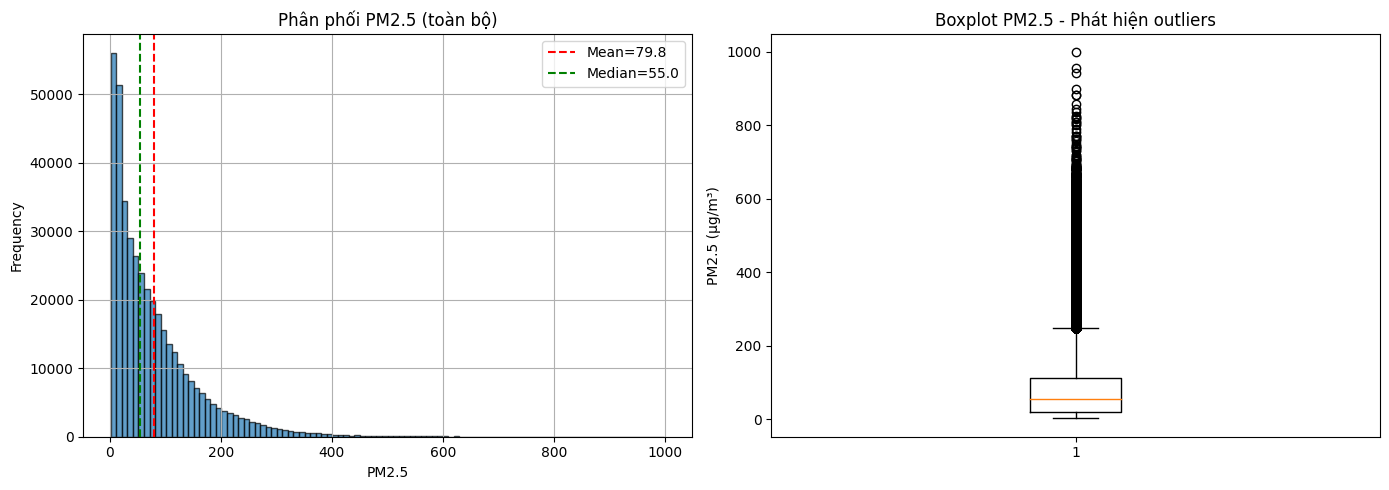


📈 Đánh giá phân phối:
   Skewness: 2.014 (lệch phải - positive skew)
   Kurtosis: 5.965 (đuôi nặng - heavy tails)

   → PM2.5 có phân phối lệch phải mạnh với đuôi nặng
   → Có nhiều giá trị cực cao (ô nhiễm nặng) nhưng đa số giá trị thấp-trung bình


In [9]:
# Phân tích outliers và phân phối lệch của PM2.5
print("="*60)
print("PHÁT HIỆN OUTLIERS VÀ PHÂN PHỐI LỆCH")
print("="*60)

# Lấy dữ liệu PM2.5 (bỏ missing)
pm25_data = df['PM2.5'].dropna()

print(f"\n📊 Thống kê mô tả PM2.5:")
print(f"   Count:  {len(pm25_data):,}")
print(f"   Mean:   {pm25_data.mean():.2f}")
print(f"   Median: {pm25_data.median():.2f}")
print(f"   Std:    {pm25_data.std():.2f}")
print(f"   Min:    {pm25_data.min():.2f}")
print(f"   Max:    {pm25_data.max():.2f}")
print(f"\n   Quantiles:")
for q in [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]:
    print(f"   Q{int(q*100):02d}:   {pm25_data.quantile(q):.2f}")

# Phát hiện outliers bằng IQR
Q1 = pm25_data.quantile(0.25)
Q3 = pm25_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = pm25_data[(pm25_data < lower_bound) | (pm25_data > upper_bound)]

print(f"\n🔍 Phát hiện Outliers (IQR method):")
print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"   Lower bound: {lower_bound:.2f}")
print(f"   Upper bound: {upper_bound:.2f}")
print(f"   Số outliers: {len(outliers):,} ({len(outliers)/len(pm25_data)*100:.2f}%)")

# Histogram và Boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
pm25_data.hist(bins=100, ax=ax1, alpha=0.7, edgecolor='black')
ax1.axvline(pm25_data.mean(), color='red', linestyle='--', label=f'Mean={pm25_data.mean():.1f}')
ax1.axvline(pm25_data.median(), color='green', linestyle='--', label=f'Median={pm25_data.median():.1f}')
ax1.set_xlabel('PM2.5')
ax1.set_ylabel('Frequency')
ax1.set_title('Phân phối PM2.5 (toàn bộ)')
ax1.legend()

ax2 = axes[1]
ax2.boxplot(pm25_data, vert=True)
ax2.set_ylabel('PM2.5 (μg/m³)')
ax2.set_title('Boxplot PM2.5 - Phát hiện outliers')

plt.tight_layout()
plt.show()

# Đánh giá độ lệch (skewness)
skewness = pm25_data.skew()
kurtosis = pm25_data.kurtosis()
print(f"\n📈 Đánh giá phân phối:")
print(f"   Skewness: {skewness:.3f} {'(lệch phải - positive skew)' if skewness > 0 else '(lệch trái - negative skew)'}")
print(f"   Kurtosis: {kurtosis:.3f} {'(đuôi nặng - heavy tails)' if kurtosis > 0 else '(đuôi nhẹ - light tails)'}")
print(f"\n   → PM2.5 có phân phối lệch phải mạnh với đuôi nặng")
print(f"   → Có nhiều giá trị cực cao (ô nhiễm nặng) nhưng đa số giá trị thấp-trung bình")

## Q1.4 — Vẽ chuỗi PM2.5 theo thời gian
Mục tiêu: Vẽ toàn giai đoạn để thấy xu hướng dài hạn, và zoom 1-2 tháng để thấy dao động ngắn hạn.

📍 Phân tích chuỗi thời gian PM2.5 cho trạm: Aotizhongxin
   Số bản ghi: 35,064


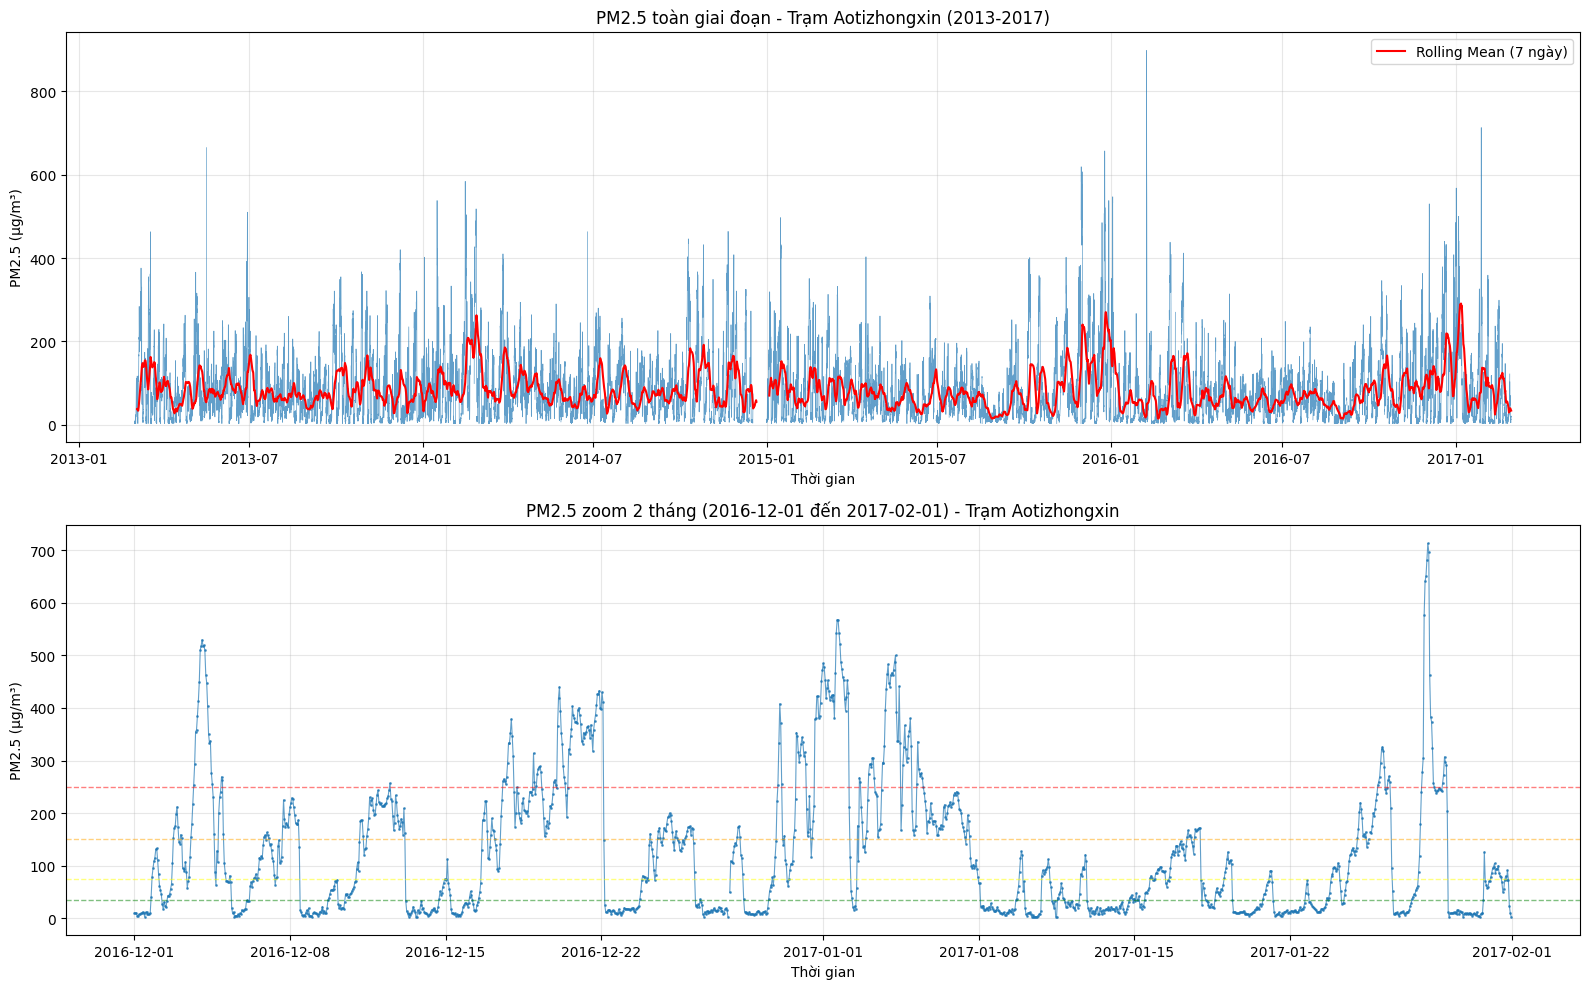


📈 Nhận xét từ đồ thị:
   1. Có xu hướng mùa vụ rõ ràng: PM2.5 cao vào mùa đông (tháng 11-2), thấp vào mùa hè
   2. Có các đợt spike (đỉnh ô nhiễm) tăng vọt, đặc biệt trong mùa đông
   3. Dao động theo ngày rõ ràng khi zoom vào 2 tháng
   4. Rolling mean 7 ngày cho thấy xu hướng dài hạn ổn định


In [10]:
# Vẽ chuỗi PM2.5 theo thời gian - chọn 1 trạm để phân tích
ANALYSIS_STATION = 'Aotizhongxin'
df_station = df[df['station'] == ANALYSIS_STATION].sort_values('datetime').copy()

print(f"📍 Phân tích chuỗi thời gian PM2.5 cho trạm: {ANALYSIS_STATION}")
print(f"   Số bản ghi: {len(df_station):,}")

# Figure 1: Toàn giai đoạn
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

ax1 = axes[0]
ax1.plot(df_station['datetime'], df_station['PM2.5'], linewidth=0.5, alpha=0.7)
# Thêm rolling mean 7 ngày
rolling_mean = df_station['PM2.5'].rolling(window=24*7, min_periods=24*3).mean()
ax1.plot(df_station['datetime'], rolling_mean, color='red', linewidth=1.5, label='Rolling Mean (7 ngày)')
ax1.set_xlabel('Thời gian')
ax1.set_ylabel('PM2.5 (μg/m³)')
ax1.set_title(f'PM2.5 toàn giai đoạn - Trạm {ANALYSIS_STATION} (2013-2017)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Figure 2: Zoom 2 tháng (tháng 12/2016 - tháng 1/2017, thường có ô nhiễm cao)
zoom_start = '2016-12-01'
zoom_end = '2017-02-01'
df_zoom = df_station[(df_station['datetime'] >= zoom_start) & (df_station['datetime'] < zoom_end)]

ax2 = axes[1]
ax2.plot(df_zoom['datetime'], df_zoom['PM2.5'], linewidth=0.8, marker='.', markersize=2, alpha=0.7)
ax2.set_xlabel('Thời gian')
ax2.set_ylabel('PM2.5 (μg/m³)')
ax2.set_title(f'PM2.5 zoom 2 tháng ({zoom_start} đến {zoom_end}) - Trạm {ANALYSIS_STATION}')
ax2.grid(True, alpha=0.3)

# Đánh dấu các mức nguy hiểm theo AQI
for level, (threshold, color, label) in enumerate([
    (35, 'green', 'Good (0-35)'),
    (75, 'yellow', 'Moderate (35-75)'),
    (150, 'orange', 'Unhealthy for Sensitive Groups'),
    (250, 'red', 'Unhealthy'),
]):
    ax2.axhline(y=threshold, color=color, linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

print("\n📈 Nhận xét từ đồ thị:")
print("   1. Có xu hướng mùa vụ rõ ràng: PM2.5 cao vào mùa đông (tháng 11-2), thấp vào mùa hè")
print("   2. Có các đợt spike (đỉnh ô nhiễm) tăng vọt, đặc biệt trong mùa đông")
print("   3. Dao động theo ngày rõ ràng khi zoom vào 2 tháng")
print("   4. Rolling mean 7 ngày cho thấy xu hướng dài hạn ổn định")

## Q1.5 — Kiểm tra tự tương quan (Autocorrelation)
Mục tiêu: So sánh tương quan của PM2.5 với các độ trễ 24h (chu kỳ ngày) và 168h (chu kỳ tuần) để gợi ý chu kỳ.

KIỂM TRA TỰ TƯƠNG QUAN (AUTOCORRELATION)

📊 Tự tương quan (Autocorrelation) tại các độ trễ:
   Lag   1h               : 0.9666
   Lag   3h               : 0.8785
   Lag   6h               : 0.7591
   Lag  12h               : 0.5910
   Lag  24h (1 ngày)      : 0.3933
   Lag  48h               : 0.1364
   Lag  72h               : 0.0591
   Lag 168h (1 tuần)      : 0.0161
   Lag 336h (2 tuần)      : 0.0685


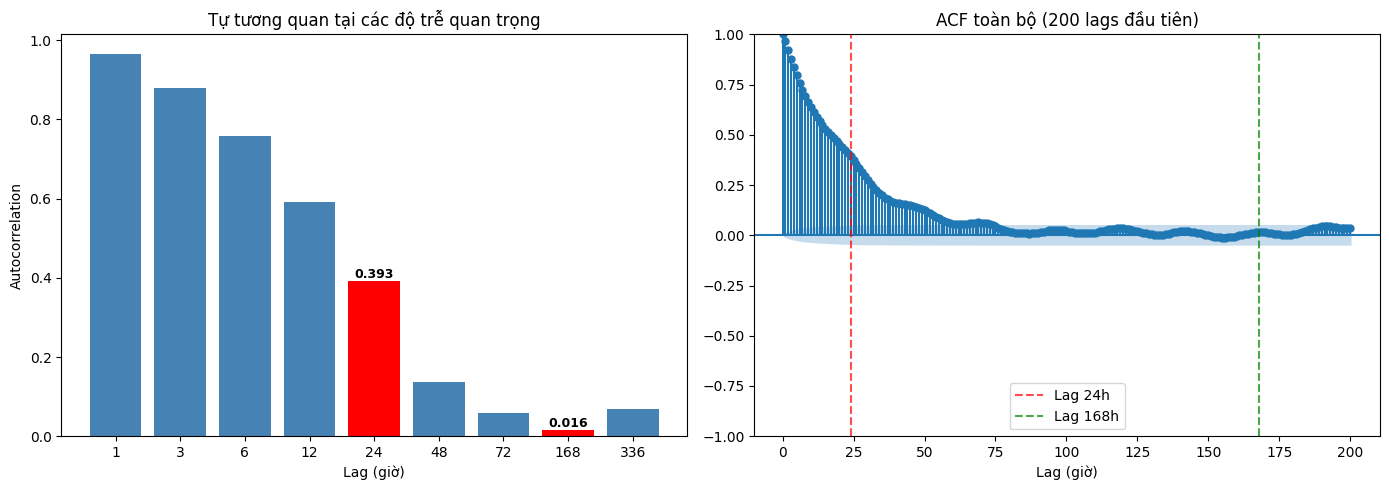


📈 Nhận xét:
   - Tự tương quan lag 1h rất cao (0.967): PM2.5 giờ này phụ thuộc mạnh vào giờ trước
   - Tự tương quan lag 24h vẫn cao (0.393): có chu kỳ ngày rõ ràng
   - Tự tương quan lag 168h (0.016): có tín hiệu chu kỳ tuần nhưng yếu hơn
   - ACF giảm chậm → chuỗi có tính persistence cao (giá trị hiện tại phụ thuộc nhiều vào quá khứ)


In [11]:
# Kiểm tra tự tương quan - Autocorrelation
print("="*60)
print("KIỂM TRA TỰ TƯƠNG QUAN (AUTOCORRELATION)")
print("="*60)

# Lấy chuỗi PM2.5 của 1 trạm, đã sort theo thời gian
pm25_series = df_station.set_index('datetime')['PM2.5'].dropna()

# Tính autocorrelation tại các lag quan trọng
lags_to_check = [1, 3, 6, 12, 24, 48, 72, 168, 336]
autocorr_values = {}

print("\n📊 Tự tương quan (Autocorrelation) tại các độ trễ:")
for lag in lags_to_check:
    if lag < len(pm25_series):
        acf_value = pm25_series.autocorr(lag=lag)
        autocorr_values[lag] = acf_value
        lag_label = ""
        if lag == 24:
            lag_label = " (1 ngày)"
        elif lag == 168:
            lag_label = " (1 tuần)"
        elif lag == 336:
            lag_label = " (2 tuần)"
        print(f"   Lag {lag:3d}h{lag_label:15s}: {acf_value:.4f}")

# Visualize autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Autocorrelation tại các lag đặc biệt
ax1 = axes[0]
lags = list(autocorr_values.keys())
acf_vals = list(autocorr_values.values())
colors = ['red' if l in [24, 168] else 'steelblue' for l in lags]
bars = ax1.bar(range(len(lags)), acf_vals, color=colors)
ax1.set_xticks(range(len(lags)))
ax1.set_xticklabels([str(l) for l in lags])
ax1.set_xlabel('Lag (giờ)')
ax1.set_ylabel('Autocorrelation')
ax1.set_title('Tự tương quan tại các độ trễ quan trọng')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Highlight lag 24 và 168
for i, (lag, val) in enumerate(autocorr_values.items()):
    if lag in [24, 168]:
        ax1.annotate(f'{val:.3f}', (i, val), ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: ACF đầy đủ (dùng statsmodels)
from statsmodels.graphics.tsaplots import plot_acf
ax2 = axes[1]
plot_acf(pm25_series, lags=200, ax=ax2, alpha=0.05)
ax2.set_xlabel('Lag (giờ)')
ax2.set_title('ACF toàn bộ (200 lags đầu tiên)')
ax2.axvline(x=24, color='red', linestyle='--', alpha=0.7, label='Lag 24h')
ax2.axvline(x=168, color='green', linestyle='--', alpha=0.7, label='Lag 168h')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📈 Nhận xét:")
print(f"   - Tự tương quan lag 1h rất cao ({autocorr_values.get(1, 0):.3f}): PM2.5 giờ này phụ thuộc mạnh vào giờ trước")
print(f"   - Tự tương quan lag 24h vẫn cao ({autocorr_values.get(24, 0):.3f}): có chu kỳ ngày rõ ràng")
print(f"   - Tự tương quan lag 168h ({autocorr_values.get(168, 0):.3f}): có tín hiệu chu kỳ tuần nhưng yếu hơn")
print("   - ACF giảm chậm → chuỗi có tính persistence cao (giá trị hiện tại phụ thuộc nhiều vào quá khứ)")

## Q1.6 — Kiểm định tính dừng (Stationarity Tests)
Mục tiêu: Chạy ADF và KPSS test để xác định chuỗi có dừng không, từ đó quyết định cần sai phân (d) hay không.

In [12]:
# Kiểm định tính dừng - Stationarity Tests
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("KIỂM ĐỊNH TÍNH DỪNG (STATIONARITY TESTS)")
print("="*60)

# ADF Test (Augmented Dickey-Fuller)
print("\n📊 ADF Test (Augmented Dickey-Fuller):")
print("   H0: Chuỗi có unit root (không dừng)")
print("   H1: Chuỗi dừng (stationary)")

adf_result = adfuller(pm25_series, autolag='AIC')
print(f"\n   ADF Statistic: {adf_result[0]:.6f}")
print(f"   p-value:       {adf_result[1]:.6f}")
print(f"   Lags used:     {adf_result[2]}")
print(f"   Observations:  {adf_result[3]}")
print("   Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n   ✅ KẾT LUẬN ADF: p-value < 0.05 → Bác bỏ H0 → Chuỗi CÓ TÍNH DỪNG")
else:
    print("\n   ⚠️ KẾT LUẬN ADF: p-value >= 0.05 → Không bác bỏ H0 → Chuỗi KHÔNG DỪNG")

# KPSS Test
print("\n" + "-"*60)
print("\n📊 KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin):")
print("   H0: Chuỗi dừng (stationary)")
print("   H1: Chuỗi có unit root (không dừng)")

kpss_result = kpss(pm25_series, regression='c', nlags='auto')
print(f"\n   KPSS Statistic: {kpss_result[0]:.6f}")
print(f"   p-value:        {kpss_result[1]:.6f}")
print(f"   Lags used:      {kpss_result[2]}")
print("   Critical Values:")
for key, value in kpss_result[3].items():
    print(f"      {key}: {value:.4f}")

if kpss_result[1] > 0.05:
    print("\n   ✅ KẾT LUẬN KPSS: p-value > 0.05 → Không bác bỏ H0 → Chuỗi CÓ TÍNH DỪNG")
else:
    print("\n   ⚠️ KẾT LUẬN KPSS: p-value <= 0.05 → Bác bỏ H0 → Chuỗi KHÔNG DỪNG")

# Tổng hợp kết luận
print("\n" + "="*60)
print("TỔNG HỢP KẾT LUẬN VỀ TÍNH DỪNG")
print("="*60)

adf_stationary = adf_result[1] < 0.05
kpss_stationary = kpss_result[1] > 0.05

if adf_stationary and kpss_stationary:
    print("\n✅ CẢ HAI TEST đều cho thấy chuỗi DỪNG")
    print("   → Có thể sử dụng d=0 trong ARIMA")
elif adf_stationary and not kpss_stationary:
    print("\n⚠️ KẾT QUẢ MÂU THUẪN: ADF nói dừng, KPSS nói không dừng")
    print("   → Chuỗi có thể dừng theo xu hướng (trend stationary)")
    print("   → Cân nhắc d=0 hoặc d=1, kiểm tra thêm bằng ACF/PACF")
elif not adf_stationary and kpss_stationary:
    print("\n⚠️ KẾT QUẢ MÂU THUẪN: ADF nói không dừng, KPSS nói dừng")
    print("   → Cần phân tích thêm")
else:
    print("\n❌ CẢ HAI TEST đều cho thấy chuỗi KHÔNG DỪNG")
    print("   → Cần sai phân (d >= 1) trước khi áp dụng ARIMA")

KIỂM ĐỊNH TÍNH DỪNG (STATIONARITY TESTS)

📊 ADF Test (Augmented Dickey-Fuller):
   H0: Chuỗi có unit root (không dừng)
   H1: Chuỗi dừng (stationary)



   ADF Statistic: -19.526139
   p-value:       0.000000
   Lags used:     39
   Observations:  34099
   Critical Values:
      1%: -3.4305
      5%: -2.8616
      10%: -2.5668

   ✅ KẾT LUẬN ADF: p-value < 0.05 → Bác bỏ H0 → Chuỗi CÓ TÍNH DỪNG

------------------------------------------------------------

📊 KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin):
   H0: Chuỗi dừng (stationary)
   H1: Chuỗi có unit root (không dừng)

   KPSS Statistic: 0.200805
   p-value:        0.100000
   Lags used:      105
   Critical Values:
      10%: 0.3470
      5%: 0.4630
      2.5%: 0.5740
      1%: 0.7390

   ✅ KẾT LUẬN KPSS: p-value > 0.05 → Không bác bỏ H0 → Chuỗi CÓ TÍNH DỪNG

TỔNG HỢP KẾT LUẬN VỀ TÍNH DỪNG

✅ CẢ HAI TEST đều cho thấy chuỗi DỪNG
   → Có thể sử dụng d=0 trong ARIMA


## Q1.7 — Nhận xét: Biến thiếu nào đáng lo nhất cho dự báo PM2.5?

**Phân tích và kết luận:**

1. **CO (~4.92% missing)**: Đây là biến thiếu nhiều nhất. CO (Carbon Monoxide) thường có tương quan với PM2.5 vì cùng nguồn phát thải (giao thông, đốt nhiên liệu). Tuy nhiên, CO không phải đặc trưng chính để dự báo PM2.5.

2. **PM2.5 (~2.08% missing)**: Đây là **biến đáng lo nhất** vì:
   - PM2.5 là **biến mục tiêu (target)** - nếu thiếu thì không có gì để dự báo
   - Với mô hình ARIMA univariate, thiếu PM2.5 sẽ tạo **gaps trong chuỗi**, ảnh hưởng đến việc học tự tương quan
   - Với mô hình regression, thiếu PM2.5 đồng nghĩa với thiếu các **lag features** (PM2.5_lag1, lag3, lag24)

3. **Biến khí tượng (TEMP, PRES, DEWP, RAIN, WSPM < 0.1%)**: Thiếu rất ít, không đáng lo. Đây là tin tốt vì các biến này là đặc trưng quan trọng cho mô hình regression/SARIMAX.

**Kết luận**: 
- Với **ARIMA**: PM2.5 thiếu là nguy hiểm nhất → cần interpolate/fill trước khi fit
- Với **Regression**: PM2.5 và CO thiếu ảnh hưởng đến lag features → cần drop rows hoặc fill hợp lý
- Chiến lược xử lý: interpolate theo thời gian cho các gaps ngắn, hoặc forward-fill nếu gaps nhỏ

In [13]:
class_dist = df['aqi_class'].value_counts(dropna=False)
class_dist

aqi_class
Unhealthy                         148558
Moderate                          109549
Unhealthy_for_Sensitive_Groups     64731
Very_Unhealthy                     56242
Hazardous                          19931
Good                               13924
NaN                                 7833
Name: count, dtype: int64

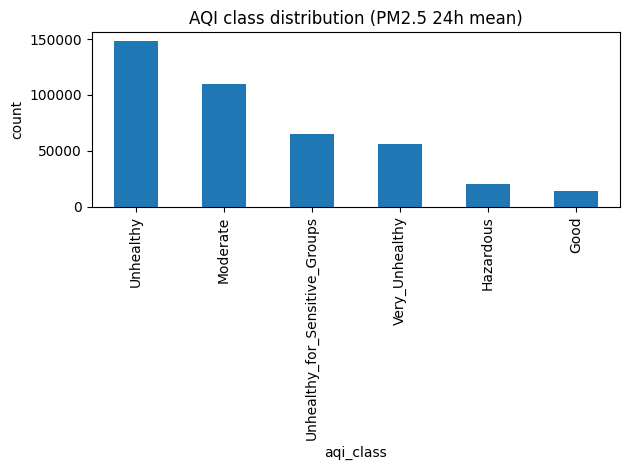

In [14]:
import matplotlib.pyplot as plt

class_dist.drop(index=[x for x in class_dist.index if pd.isna(x)], errors='ignore').plot(kind='bar')
plt.title('AQI class distribution (PM2.5 24h mean)')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [15]:
df.to_parquet(OUT_PATH, index=False)
print('Saved:', OUT_PATH)

Saved: C:\Coding\DataMining\ThucHanh\Tuan7\data\processed\cleaned.parquet
